# Axora: Clinical Document Classification
## Notebook 2 : Classification Modeling & Evaluation

---

In this notebook, we:  
1. Load the dataset and vectorizer.  
2. Train a Softmax Regression model.  
3. Perform cross-validation and basic hyperparameter tuning.  
4. Evaluate the model with accuracy, classification report, and confusion matrix.  
5. Save the trained pipeline (vectorizer + classifier) for deployment.

## 📚 Imports and Configurations  

In this step, we import all the necessary Python libraries and set up configurations for reproducibility and visualization:  

- 📊 pandas, numpy → for data handling and numerical computations  
- 📈 matplotlib, seaborn → for plots and visualizations  
- 💾 joblib → to save and load trained models and vectorizers  
- 📂 datasets (Hugging Face) → to load the clinical transcriptions dataset  
- 🤖 scikit-learn (LogisticRegression, GridSearchCV, Pipeline) → to train and tune our classification model  
- 📏 scikit-learn metrics (classification_report, confusion_matrix, accuracy_score) → for rigorous model evaluation  

We also:  
- 🎲 Set a consistent random seed (RANDOM_STATE=42) for reproducibility.  
- 🎨 Configure plot aesthetics (grid style, font size, figure size) for clear visuals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)

# Plot aesthetics
sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports ready.")


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports ready.


## 📂 Step 1: Load Dataset  

We reload the dataset (train, validation, test) from Hugging Face.  
Labels (medical_specialty) will be used as the target variable.

In [2]:
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Repo card metadata block was not found. Setting CardData to empty.


Train: (1724, 5) Val: (370, 5) Test: (370, 5)


## 💾 Step 2: Load Saved Vectorizer  

We load the TF-IDF vectorizer fitted in Notebook 1.  
This ensures consistency across preprocessing, training, and deployment.

In [3]:
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# Transform datasets
X_train = vectorizer.transform(train_df["transcription"])
X_val   = vectorizer.transform(val_df["transcription"])
X_test  = vectorizer.transform(test_df["transcription"])

y_train = train_df["medical_specialty"]
y_val   = val_df["medical_specialty"]
y_test  = test_df["medical_specialty"]

print("Data transformed using loaded vectorizer")
print("X_train:", X_train.shape, "y_train:", y_train.shape)


Data transformed using loaded vectorizer
X_train: (1724, 7568) y_train: (1724,)


## 🤖 Step 3: Train Softmax Regression  

We implement *multinomial logistic regression* (Softmax regression).  
The saga solver is efficient for large, sparse datasets like TF-IDF.

In [4]:
clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print("Logistic Regression model trained.")


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression model trained.


## 🔍 Step 4: Cross-Validation and Hyperparameter Tuning  

We use cross-validation on the training set and test different values of C (inverse regularization strength).

In [5]:
param_grid = {"C": [0.1, 1.0, 5.0]}
grid = GridSearchCV(
    LogisticRegression(
        multi_class="multinomial", solver="saga",
        max_iter=300, random_state=RANDOM_STATE, n_jobs=-1
    ),
    param_grid, cv=3, n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'C': 5.0}
Best CV score: 0.784223602484472


## 📊 Step 5: Rigorous Evaluation  

We evaluate using:  
- ✅ Overall accuracy.  
- 📑 Per-class precision, recall, and F1-score.  
- 🔵Confusion matrix heatmap for error analysis.

Validation Accuracy: 0.7594594594594595

Classification Report (Validation):
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.78      0.96      0.86       107
      ENT - Otolaryngology       1.00      0.38      0.56        13
          Gastroenterology       0.86      0.86      0.86        29
     Hematology - Oncology       0.85      0.58      0.69        19
                Nephrology       1.00      0.31      0.48        16
                 Neurology       0.67      0.62      0.65        48
              Neurosurgery       0.17      0.15      0.16        13
   Obstetrics / Gynecology       0.92      0.96      0.94        24
             Ophthalmology       1.00      0.80      0.89        10
                Orthopedic       0.71      0.85      0.77        62
     Pediatrics - Neonatal       0.69      0.90      0.78        10
   Psychiatry / Psychology       0.88      0.70      0.78        10
                 Radiology       0.00 

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

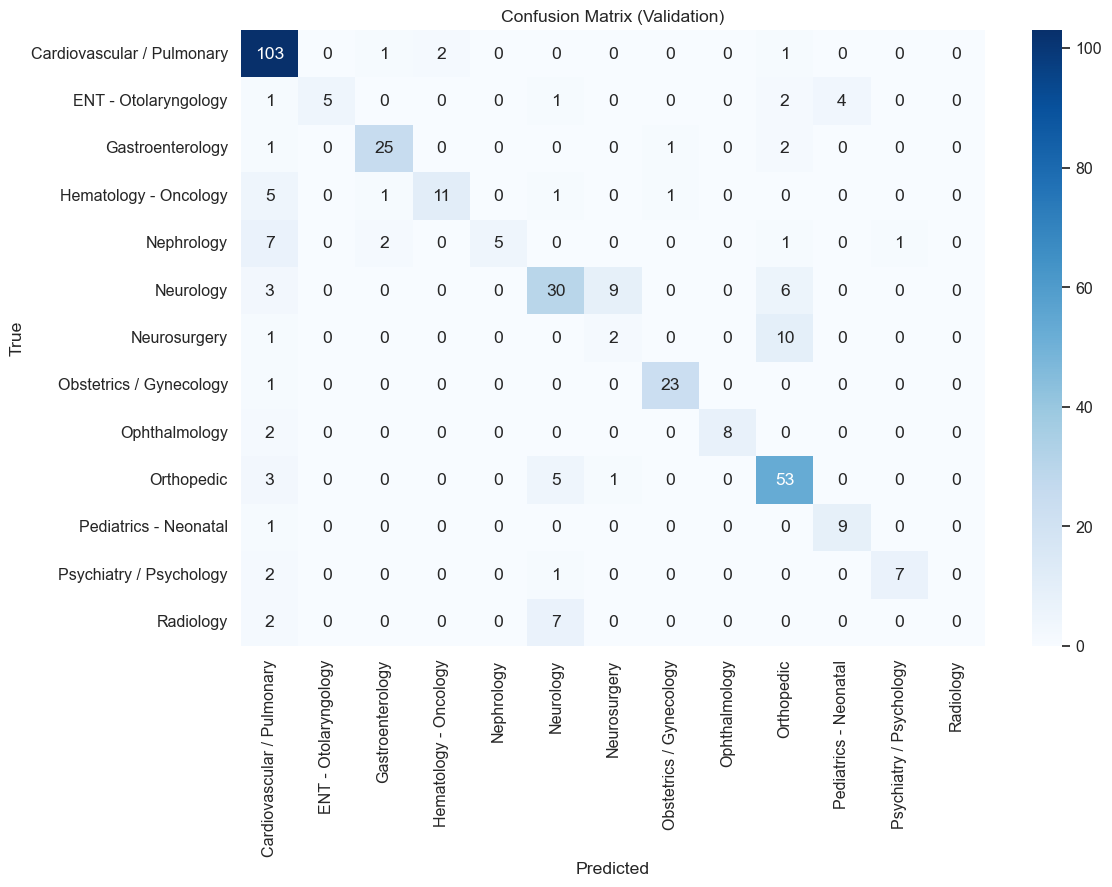

In [6]:
# Predictions
y_val_pred = clf.predict(X_val)

# Accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# Classification report
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 📦 Step 6: Save Full Pipeline  

We save the final pipeline (TF-IDF vectorizer + trained classification model).  
This pipeline is the artifact that will be deployed to *Google Cloud Vertex AI* for production use.

In [7]:
pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("classifier", clf)
])

joblib.dump(pipeline, "../artifacts/model.joblib")
print("Pipeline saved at model.joblib")


Pipeline saved at model.joblib
